In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import datetime
from power_perceiver.load_raw.data_sources.raw_satellite_data_source import RawSatelliteDataSource
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]


# ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"
ZARR_PATH = "/media/jack/wd_18tb/data/ocf/satellite/v3/eumetsat_seviri_hrv_uk.zarr"


def _get_sat_data_source(
    zarr_path=ZARR_PATH,
    height_in_pixels=128,
    width_in_pixels=256,
    history_duration=datetime.timedelta(hours=1),
    forecast_duration=datetime.timedelta(hours=2),
    start_date=datetime.datetime(year=2020, month=1, day=1),
    end_date=datetime.datetime(year=2020, month=12, day=31, hour=23, minute=59),
):
    return RawSatelliteDataSource(
        zarr_path=zarr_path,
        roi_height_pixels=height_in_pixels,
        roi_width_pixels=width_in_pixels,
        history_duration=history_duration,
        forecast_duration=forecast_duration,
        start_date=start_date,
        end_date=end_date,
    )


In [5]:
sat_data_source = _get_sat_data_source()

In [6]:
sat_data_source.per_worker_init(worker_id=1)

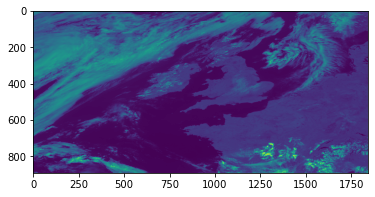

In [7]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(
    sat_data_source._data_on_disk.sel(time_utc="2020-06-01 12:00", channel="HRV").values,
    origin="upper"
    );

In [8]:
from power_perceiver.consts import Location



selection = sat_data_source._get_spatial_slice(
    sat_data_source._data_on_disk,
    Location(
        x=sat_data_source._data_on_disk.x_osgb[400, 800],
        y=sat_data_source._data_on_disk.y_osgb[400, 800]
        
    )
)

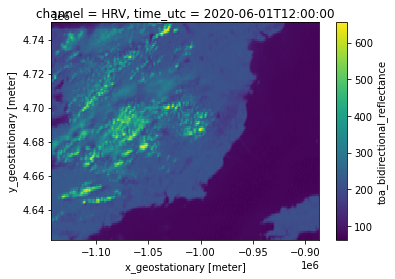

In [10]:
selection.sel(time_utc="2020-06-01 12:00", channel="HRV").plot.pcolormesh()

In [13]:
%%time
periods = sat_data_source.get_contiguous_t0_time_periods()

CPU times: user 9.7 ms, sys: 57 µs, total: 9.76 ms
Wall time: 28.8 ms


In [14]:
import xarray as xr

In [15]:
%%time

data_to_load = []
for _, row in periods.iterrows():
    data_for_period = sat_data_source._data_on_disk.sel(time_utc=slice(row["start_dt"], row["end_dt"]))
    data_to_load.append(data_for_period)
    
data_to_load = xr.concat(data_to_load, dim="time_utc")

CPU times: user 470 ms, sys: 4.07 ms, total: 474 ms
Wall time: 474 ms


In [16]:
data_to_load

<xarray.DataArray 'data' (time_utc: 41966, channel: 1, y_geostationary: 891,
                          x_geostationary: 1843)>
dask.array<concatenate, shape=(41966, 1, 891, 1843), dtype=int16, chunksize=(22, 1, 891, 1843), chunktype=numpy.ndarray>
Coordinates:
  * channel          (channel) <U3 'HRV'
  * x_geostationary  (x_geostationary) float32 -1.814e+06 -1.813e+06 ... 2.8e+04
  * y_geostationary  (y_geostationary) float32 5.088e+06 5.087e+06 ... 4.198e+06
  * time_utc         (time_utc) datetime64[ns] 2020-01-01T09:15:00 ... 2020-1...
    x_osgb           (y_geostationary, x_geostationary) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
    y_osgb           (y_geostationary, x_geostationary) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Attributes:
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    calibration:                            reflectance
    coordinates:                            acq_time
    georef_offset_corrected:                True
    modifiers:                              []
    name:                                   HRV
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    platform_name:                          Meteosat-10
    reader:                                 seviri_l1b_native
    resolution:                             1000.134348869
    sensor:                                 seviri
    standard_name:                          toa_bidirectional_reflectance
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             [0.5, 0.7, 0.9, 'µm']

In [17]:
sat_data_source.load_subset_into_ram(periods[:3])

In [18]:
import pandas as pd
from power_perceiver.consts import Location

xr_example = sat_data_source.get_example(
    t0_datetime_utc=pd.Timestamp("2020-01-01 12:00"),
    center_osgb=Location(x=66400, y=357563),
)

In [19]:
xr_example

<xarray.DataArray 'data' (time_utc: 37, channel: 1, y_geostationary: 128,
                          x_geostationary: 256)>
array([[[[-0.14758198, -0.14651358, -0.1497188 , ..., -0.17856583,
          -0.17856583, -0.18070264],
         [-0.14544517, -0.14010313, -0.14330836, ..., -0.18070264,
          -0.17856583, -0.17749742],
         [-0.14010313, -0.13903472, -0.1358295 , ..., -0.17856583,
          -0.17856583, -0.18070264],
         ...,
         [-0.09202475, -0.08988794, -0.08988794, ..., -0.0845459 ,
          -0.0845459 , -0.0845459 ],
         [-0.09629839, -0.09522998, -0.09522998, ..., -0.0845459 ,
          -0.0845459 , -0.0856143 ],
         [-0.09522998, -0.09522998, -0.09202475, ..., -0.0845459 ,
          -0.08240908, -0.0856143 ]]],


       [[[-0.14223994, -0.14223994, -0.14223994, ..., -0.176429  ,
          -0.176429  , -0.176429  ],
         [-0.14223994, -0.14223994, -0.14223994, ..., -0.17749742,
          -0.17749742, -0.17856583],
         [-0.13903472, -0.14010313, -0.14010313, ..., -0.176429  ,
...
          -0.09736679, -0.09522998],
         [-0.12300859, -0.11980337, -0.12087177, ..., -0.10805088,
          -0.10377724, -0.09736679],
         [-0.12621382, -0.12087177, -0.12300859, ..., -0.10911929,
          -0.10698247, -0.10377724]]],


       [[[-0.12728223, -0.12621382, -0.124077  , ..., -0.1379663 ,
          -0.1379663 , -0.1379663 ],
         [-0.12300859, -0.12621382, -0.12835063, ..., -0.1358295 ,
          -0.1379663 , -0.13476108],
         [-0.11446133, -0.124077  , -0.13262427, ..., -0.13155586,
          -0.13476108, -0.13048746],
         ...,
         [-0.1379663 , -0.13476108, -0.13155586, ..., -0.12621382,
          -0.12300859, -0.11659814],
         [-0.13476108, -0.13262427, -0.13048746, ..., -0.11980337,
          -0.11980337, -0.11552974],
         [-0.1358295 , -0.13155586, -0.12835063, ..., -0.11980337,
          -0.11980337, -0.11552974]]]], dtype=float32)
Coordinates:
  * channel          (channel) <U3 'HRV'
  * x_geostationary  (x_geostationary) float32 -1.142e+06 ... -8.871e+05
  * y_geostationary  (y_geostationary) float32 4.75e+06 4.749e+06 ... 4.623e+06
  * time_utc         (time_utc) datetime64[ns] 2020-01-01T11:00:00 ... 2020-0...
    x_osgb           (y_geostationary, x_geostationary) float32 -1.105e+05 .....
    y_osgb           (y_geostationary, x_geostationary) float32 5.304e+05 ......

In [21]:
np_example = sat_data_source.to_numpy(xr_example)

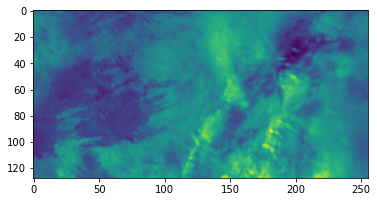

In [22]:
from power_perceiver.consts import BatchKey

plt.imshow(np_example[BatchKey.hrvsatellite][-1, 0])